https://research.aalto.fi/en/datasets/iot-devices-captures
https://arxiv.org/pdf/1611.04880.pdf
https://sci-hub.se/https://ieeexplore.ieee.org/document/7980220

In [8]:
import re
import os
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt

from scapy.all import *
# from scapy.layers.ssl_tls import *
# !pip install scapy-ssl_tls
load_layer('tls')

### faetures extraction

###### Protocols and features:

1. EAPOL
    - src ip
    - dst ip
2. MDNS
    - dst ip
    - Answers
3. SSDP
    - dst ip
    - packet size
4. DNS
    - Answers
5. TCP
    - packet size
    - tsval
6. TLS server hello
    - SNI
    - session id
    - ja3
7. UDP
    - packet size

In [2]:
def extract_features(packet):
    features = {}

    if packet.haslayer(EAPOL):
        features['protocol'] = 'EAPOL'
        features['src_mac'] = packet.src
        features['dst_mac'] = packet.dst

#     elif packet.haslayer(MDNS):
#         if packet.haslayer(IP):
#             features['dst_ip'] = packet[IP].dst 
#             features['answers'] = packet[MDNS].an

#     elif packet.haslayer(SSDP):
#         if packet.haslayer(IP):
#             features['dst_ip'] = packet[IP].dst
#             features['packet_size'] = len(packet)
    features['protocol'] = list()
    if packet.haslayer(DNS):
        features['protocol'].append('DNS')
        features['answers'] = list()
        a_count = packet[DNS].ancount
        for i in range(0, a_count-1):
            features['answers'].append(packet[DNS].an[i].rrname)
            features['answers'].append(packet[DNS].an[i].rdata)
#         features['answers'] = packet[DNS].an

    if packet.haslayer(TCP):
        features['protocol'].append('TCP')
        features['packet_size'] = len(packet)
        if packet.haslayer(TCP) and len(packet[TCP].options) > 2:
            features['tsval'] = packet[TCP].options[2][1]
            features['src_ip'] = packet[IP].src
            features['dst_ip'] = packet[IP].dst

    if TLS in packet and hasattr(packet[TLS], 'msg'):
        if packet[TLS].msg and hasattr(packet[TLS].msg[0], 'msgtype'):
            if packet[TLS].msg[0].msgtype == 2:  # Server Hello
                features['protocol'].append('TLS')
        #         if packet.haslayer(SSLv2):
                features['session_id'] = packet[TLS].msg[0].sid#.decode()
    #                             features['sni'] = ''
            if hasattr(packet[TLS], 'TLS_Ext_ServerName'): #'TLS_Ext_ServerName' in packet[TLS].msg[0]:
                print(packet)
                print(packet[TLS][TLS_Ext_ServerName].servernames[0].servername.decode(), packet[TLS][TLS_Ext_ServerName].servernames[0].servername)
                features['sni'] = packet[TLS][TLS_Ext_ServerName].servernames[0].servername.decode()
    #                             features['ja3'] = packet[SSLv2].ja3_hash
            if 'TLSCertificate' in packet[TLS] and packet[TLS][TLSCertificate].certs[0]:
                snis = []
                emails = []
                for a in packet[TLS][TLSCertificate].certs[0]:
                    sni_pattern = r'CN=([\w.-]+)'
                    email_pattern = r'[\w.-]+@[a-zA-Z]+\.[a-zA-Z]{2,}'
                    a = str(a)
                    snis.append(re.findall(sni_pattern, a))
                    emails.append(re.findall(email_pattern, a))
                features['sni'] = snis+emails
#     if packet.haslayer(TLS) and packet[TLS].msg[0].msgtype == 2:  # Server Hello
#         features['protocol'] = 'TLS'
# #         if packet.haslayer(SSLv2):
#         features['session_id'] = packet[TLS].msg[0].sid.decode()
#         features['sni'] = packet[TLS][TLS_Ext_ServerName].servernames[0].servername.decode()
# #             features['ja3'] = packet[SSLv2].ja3_hash

    if packet.haslayer(UDP):
        features['protocol'].append('UDP')
        features['packet_size'] = len(packet)

    return features

In [3]:
def save_to_dataframe(packets, pcap_file, pcap_folder, filename):
#     data = []
    columns = ['timestamp', 'device', 'pcap_folder', 'answers', 'dst_mac', 'packet_size', 'pcap_file',
               'pcap_folder', 'src_mac', 'timestamp', 'tsval']
    for packet in packets:
        row = {'timestamp': float(packet.time), 'device': filename, 'pcap_folder': pcap_folder}
        row.update(extract_features(packet))
        data.append(row)

#     df = pd.DataFrame(data)
#     return df

In [4]:
data = []

for root, subdirs, files in os.walk('./data/captures_IoT-Sentinel/'):
#     print(root)
    for file in files:
#         print(file)
        filename, file_extension = os.path.splitext(file)
        if file_extension == '.pcap':
            pcap_file = os.path.join(root, file)
            pcap_folder = root.split(sep=os.sep)[-1]
            packets = rdpcap(pcap_file)
#             print(root.split(sep=os.sep)[-1], file)
            print(pcap_file)
            _ = save_to_dataframe(packets, pcap_file, pcap_folder, filename)

./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-A-2-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-8-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-1-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-9-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-14-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-13-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-A-5-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-5-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-3-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-12-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-15-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-A-1-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-10-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-6-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-11-STA.pcap
./data/captures_Io

./data/captures_IoT-Sentinel/HueSwitch/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-8-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-10-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-2-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-8-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-1-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-9-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-5-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-5-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-3-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-9-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-1-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-7-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-10-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-6-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-2-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-3-STA.pcap
./data/captu

./data/captures_IoT-Sentinel/WeMoLink/Setup-C-3-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-9-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-14-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-1-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-7-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-12-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-13-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-C-2-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-3-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-11-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-6-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-4-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-16-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-8-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-1-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-9-STA.pcap
.

./data/captures_IoT-Sentinel/D-LinkDoorSensor/Setup-C-2-STA.pcap
./data/captures_IoT-Sentinel/D-LinkDoorSensor/Setup-C-20-STA.pcap
./data/captures_IoT-Sentinel/D-LinkDoorSensor/Setup-C-7-STA.pcap
./data/captures_IoT-Sentinel/D-LinkDoorSensor/Setup-C-19-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-16-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-8-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-1-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-9-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-14-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-13-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-18-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-17-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-5-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-3-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-12-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-15

In [5]:
df = pd.DataFrame(data)
df

,timestamp,device,pcap_folder,protocol,src_mac,dst_mac,packet_size,answers,tsval,src_ip,dst_ip,session_id,sni
0,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,[],90:8d:78:a9:3d:6f,28:b2:bd:c3:41:78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,[],90:8d:78:a9:3d:6f,28:b2:bd:c3:41:78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,[UDP],NaN,NaN,351.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,[UDP],NaN,NaN,363.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193416,1.473251e+09,Setup-A-4-STA,SmarterCoffee,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193417,1.473251e+09,Setup-A-4-STA,SmarterCoffee,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193418,1.473251e+09,Setup-A-4-STA,SmarterCoffee,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193419,1.473251e+09,Setup-A-4-STA,SmarterCoffee,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.to_csv('./data/captures_IoT-Sentinel/dataset.csv', index=False)

<AxesSubplot:ylabel='protocol'>

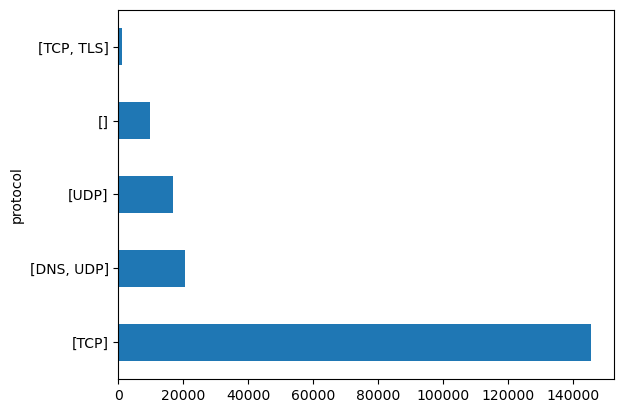

In [12]:
df.protocol.value_counts().plot(kind='barh')

### research

In [131]:
a = str(packet[TLS][TLSCertificate].certs[0][1])
a

'[X.509 Cert. Subject:/C=US/ST=CA/L=San Francisco/O=Splunk Inc./OU=Mobile Intelligence/CN=ticks2.bugsense.com/emailAddress=mobileops@splunk.com, Issuer:/C=US/ST=DE/L=Delaware/O=BugSense Inc./OU=Certificate Authority/CN=Certificate Authority/emailAddress=ops@bugsense.com]'

In [132]:
sni_pattern = r'CN=([\w.-]+)'
email_pattern = r'[\w.-]+@[a-zA-Z]+\.[a-zA-Z]{2,}'

# Find all matches for websites and emails in the input string
snis = re.findall(sni_pattern, a)
emails = re.findall(email_pattern, a)

In [133]:
snis, emails

(['ticks2.bugsense.com', 'Certificate'],
 ['mobileops@splunk.com', 'ops@bugsense.com'])

In [135]:
packet[TLS]

<TLS  type=handshake version=TLS 1.0 len=89    [deciphered_len= 89] iv=b'' msg=[<TLSServerHello  msgtype=server_hello msglen=85 version=TLS 1.0 gmt_unix_time=Mon, 05 Jan 2015 10:28:59 +0000 (1420453739) random_bytes=5d6854ef1564af8ab133412de251d0ce911d989166ff92977ca44414 sidlen=32 sid='bie^\x13\x04L\\xd0\\xdb\t\\xac\\xef\n\\xe1\x03\x13\\x85\\x82\\x91\\xd7}:H\x02\\xa5\\xa1q\\xa3\\x95%)\\xd2' cipher=TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA comp=null extlen=13 ext=[<TLS_Ext_RenegotiationInfo  type=renegotiation_info len=1 reneg_conn_len=0 |>, <TLS_Ext_SupportedPointFormat  type=ec_point_formats len=4 ecpllen=3 ecpl=[uncompressed, ansiX962_compressed_prime, ansiX962_compressed_char2] |>] |>] mac=b'' pad=b'' padlen=None |<TLS  type=handshake version=TLS 1.0 len=726    [deciphered_len= 726] iv=b'' msg=[<TLSCertificate  msgtype=certificate msglen=722 certslen=719 certs=[(716, [X.509 Cert. Subject:/C=US/ST=CA/L=San Francisco/O=Splunk Inc./OU=Mobile Intelligence/CN=ticks2.bugsense.com/emailAddress=m

In [130]:
pcap_file = './data/captures_IoT-Sentinel/WeMoInsightSwitch/Setup-C-4-STA.pcap'
pcap_folder = 'folder_name'

# for root, subdirs, files in os.walk('./data/captures_IoT-Sentinel/'):
# #     print(root)
#     for file in files:
#         filename, file_extension = os.path.splitext(file)
#         if file_extension == '.pcap':

#             pcap_file = os.path.join(root, file)
#             pcap_folder = root.split(sep=os.sep)[-1]
#             print(pcap_file)
packets = rdpcap(pcap_file)
for packet in packets:
#     if packet.haslayer(SSLv2):
#         packet.show()
#         break
#     if packet.haslayer(TLS):
#         packet.show()
#         break
    if TLS in packet and hasattr(packet[TLS], 'msg'):
        if packet[TLS].msg and hasattr(packet[TLS].msg[0], 'msgtype'):
            if packet[TLS].msg[0].msgtype == 2:  # Server Hello
                if hasattr(packet[TLS].msg[0], 'TLS_Ext_ServerName') or packet[TLS][TLSCertificate].certs[0][1]: #'TLS_Ext_ServerName' in packet[TLS].msg[0]:
                    packet.show()
                    break


###[ Ethernet ]### 
  dst       = 94:10:3e:41:c2:05
  src       = 00:b5:6d:06:08:ba
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x8
     len       = 1064
     id        = 21376
     flags     = DF
     frag      = 0
     ttl       = 42
     proto     = tcp
     chksum    = 0xdccb
     src       = 50.18.213.194
     dst       = 10.10.10.158
     \options   \
###[ TCP ]### 
        sport     = https
        dport     = 3483
        seq       = 2070166539
        ack       = 3913095835
        dataofs   = 8
        reserved  = 0
        flags     = A
        window    = 45
        chksum    = 0x6a48
        urgptr    = 0
        options   = [('NOP', None), ('NOP', None), ('Timestamp', (376015092, 4294912833))]
###[ TLS ]### 
           type      = handshake
           version   = TLS 1.0
           len       = 89    [deciphered_len= 89]
           iv        = b''
           \msg       \
            |###[ TLS Handshake - Server Hello ]### 
      

In [45]:
data = []

for root, subdirs, files in os.walk('./data/captures_IoT-Sentinel/'):
#     print(root)
    for file in files:
        filename, file_extension = os.path.splitext(file)
        if file_extension == '.pcap':
            print(pcap_file)
            pcap_file = os.path.join(root, file)
            pcap_folder = root.split(sep=os.sep)[-1]
            
            columns = ['timestamp', 'device', 'pcap_folder', 'answers', 'dst_mac', 'packet_size', 'pcap_file',
                       'pcap_folder', 'src_mac', 'timestamp', 'tsval']
            
            packets = rdpcap(pcap_file)
            for packet in packets:
                row = {'timestamp': float(packet.time), 'device': filename, 'pcap_folder': pcap_folder}
                features = {}

                if packet.haslayer(EAPOL):
                    features['protocol'] = 'EAPOL'
                    features['src_mac'] = packet.src
                    features['dst_mac'] = packet.dst

            #     elif packet.haslayer(MDNS):
            #         if packet.haslayer(IP):
            #             features['dst_ip'] = packet[IP].dst 
            #             features['answers'] = packet[MDNS].an

            #     elif packet.haslayer(SSDP):
            #         if packet.haslayer(IP):
            #             features['dst_ip'] = packet[IP].dst
            #             features['packet_size'] = len(packet)

                if packet.haslayer(DNS):
                    features['protocol'] = 'DNS'
                    features['answers'] = list()
                    a_count = packet[DNS].ancount
                    for i in range(0, a_count-1):
                        features['answers'].append(packet[DNS].an[i].rrname)
                        features['answers'].append(packet[DNS].an[i].rdata)
            #         features['answers'] = packet[DNS].an

                if packet.haslayer(TCP):
                    features['protocol'] = 'TCP'
                    features['packet_size'] = len(packet)
                    if packet.haslayer(TCP) and len(packet[TCP].options) > 2:
                        features['tsval'] = packet[TCP].options[2][1]
                        features['src_ip'] = packet[IP].src
                        features['dst_ip'] = packet[IP].dst
                        features['src_port'] = packet[IP].sport
                        features['dst_port'] = packet[IP].dport

                if TLS in packet and hasattr(packet[TLS], 'msg') and packet[TLS].msg and hasattr(packet[TLS].msg[0], 'msgtype'):
                    if packet[TLS].msg[0].msgtype == 2:  # Server Hello
                        features['protocol'] = 'TLS'
                #         if packet.haslayer(SSLv2):
                        features['session_id'] = packet[TLS].msg[0].sid#.decode('unicode_escape')
                        features['sni'] = ''
                        if hasattr(packet[TLS].msg[0], 'TLS_Ext_ServerName'): #'TLS_Ext_ServerName' in packet[TLS].msg[0]:
                            features['sni'] = packet[TLS][TLS_Ext_ServerName].servernames[0].servername.decode()
                #             features['ja3'] = packet[SSLv2].ja3_hash

                if packet.haslayer(UDP):
                    features['protocol'] = 'UDP'
                    features['packet_size'] = len(packet)

                
                
                row.update(features)
                data.append(row)
df = pd.DataFrame(data)

./data/captures_IoT-Sentinel/D-LinkSensor/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-A-2-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-8-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-1-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-9-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-14-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-13-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-A-5-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-5-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-3-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-12-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-15-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-A-1-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-10-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-6-STA.pcap
./data/captures_IoT

./data/captures_IoT-Sentinel/Lightify/Setup-C-7-STA.pcap
./data/captures_IoT-Sentinel/Lightify/Setup-C-19-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-8-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-10-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-2-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-8-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-1-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-9-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-5-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-5-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-3-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-9-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-1-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-7-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-10-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-6-STA.pcap
./data/captur

./data/captures_IoT-Sentinel/WeMoLink/Setup-A-5-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-C-5-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-C-3-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-9-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-14-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-1-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-7-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-12-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-13-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-C-2-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-3-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-11-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-6-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-4-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-16-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-8-STA.pcap
./data/capt

./data/captures_IoT-Sentinel/D-LinkDoorSensor/Setup-C-6-STA.pcap
./data/captures_IoT-Sentinel/D-LinkDoorSensor/Setup-C-11-STA.pcap
./data/captures_IoT-Sentinel/D-LinkDoorSensor/Setup-C-2-STA.pcap
./data/captures_IoT-Sentinel/D-LinkDoorSensor/Setup-C-20-STA.pcap
./data/captures_IoT-Sentinel/D-LinkDoorSensor/Setup-C-7-STA.pcap
./data/captures_IoT-Sentinel/D-LinkDoorSensor/Setup-C-19-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-16-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-8-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-1-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-9-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-14-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-13-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-18-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-17-STA.pcap
./data/captures_IoT-Sentinel/Withings/Setup-C-5-STA.pcap
./data/captures_IoT-Sentinel/Wit

In [46]:
df

,timestamp,device,pcap_folder,protocol,src_mac,dst_mac,packet_size,answers,tsval,src_ip,dst_ip,src_port,dst_port,session_id,sni
0,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,EAPOL,90:8d:78:a9:3d:6f,28:b2:bd:c3:41:78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,EAPOL,90:8d:78:a9:3d:6f,28:b2:bd:c3:41:78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,UDP,NaN,NaN,351.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,UDP,NaN,NaN,363.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193416,1.473251e+09,Setup-A-4-STA,SmarterCoffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193417,1.473251e+09,Setup-A-4-STA,SmarterCoffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193418,1.473251e+09,Setup-A-4-STA,SmarterCoffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193419,1.473251e+09,Setup-A-4-STA,SmarterCoffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193421 entries, 0 to 193420
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   timestamp    193421 non-null  float64
 1   device       193421 non-null  object 
 2   pcap_folder  193421 non-null  object 
 3   protocol     184992 non-null  object 
 4   src_mac      1275 non-null    object 
 5   dst_mac      1275 non-null    object 
 6   packet_size  183717 non-null  float64
 7   answers      20379 non-null   object 
 8   tsval        88802 non-null   object 
 9   src_ip       90235 non-null   object 
 10  dst_ip       90235 non-null   object 
 11  src_port     90235 non-null   float64
 12  dst_port     90235 non-null   float64
 13  session_id   1010 non-null    object 
 14  sni          1010 non-null    object 
dtypes: float64(4), object(11)
memory usage: 22.1+ MB


In [47]:
df.describe()

,timestamp,packet_size,src_port,dst_port
count,1.934210e+05,183717.000000,90235.000000,90235.000000
mean,1.470833e+09,329.833037,24232.972505,21000.984851
std,3.953754e+06,462.671479,23579.955129,23329.407939
min,1.460733e+09,42.000000,80.000000,80.000000
25%,1.471453e+09,66.000000,80.000000,80.000000
50%,1.472569e+09,74.000000,33218.000000,3525.000000
75%,1.473181e+09,333.000000,46763.000000,44656.500000
max,1.473773e+09,1514.000000,64978.000000,64978.000000


In [ ]:
df.to_csv('./data/captures_IoT-Sentinel/dataset.csv', index_col=0)

In [ ]:
# TLS ONLY
data = []

for root, subdirs, files in os.walk('./data/captures_IoT-Sentinel/'):
#     print(root)
    for file in files:
        filename, file_extension = os.path.splitext(file)
        if file_extension == '.pcap':
            pcap_file = os.path.join(root, file)
            pcap_folder = root.split(sep=os.sep)[-1]
            print(pcap_file)
            
            columns = ['timestamp', 'device', 'pcap_folder', 'answers', 'dst_mac', 'packet_size', 'pcap_file',
                       'pcap_folder', 'src_mac', 'timestamp', 'tsval']
            
            packets = rdpcap(pcap_file)
            for packet in packets:
                row = {'timestamp': float(packet.time), 'device': filename, 'pcap_folder': pcap_folder}
                features = {}

                if TLS in packet and hasattr(packet[TLS], 'msg'):
                    if packet[TLS].msg and hasattr(packet[TLS].msg[0], 'msgtype'):
                        if packet[TLS].msg[0].msgtype == 2:  # Server Hello
                            features['protocol'] = 'TLS'
                    #         if packet.haslayer(SSLv2):
                            features['session_id'] = packet[TLS].msg[0].sid#.decode()
#                             features['sni'] = ''
                        if hasattr(packet[TLS].msg[0], 'TLS_Ext_ServerName'): #'TLS_Ext_ServerName' in packet[TLS].msg[0]:
                            print(packet)
                            print(packet[TLS][TLS_Ext_ServerName].servernames[0].servername.decode(), packet[TLS][TLS_Ext_ServerName].servernames[0].servername)
                            features['sni'] = packet[TLS][TLS_Ext_ServerName].servernames[0].servername.decode()
#                             features['ja3'] = packet[SSLv2].ja3_hash

                
                
                row.update(features)
                data.append(row)
df = pd.DataFrame(data)

./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-A-2-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-8-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-1-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-9-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-14-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-13-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-A-5-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-5-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-3-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-12-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-15-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-A-1-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-10-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-6-STA.pcap
./data/captures_IoT-Sentinel/D-LinkSwitch/Setup-C-11-STA.pcap
./data/captures_Io

./data/captures_IoT-Sentinel/HueSwitch/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-8-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-10-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-2-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-8-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-1-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-9-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-5-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-5-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-3-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-9-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-1-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-7-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-10-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-6-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-C-2-STA.pcap
./data/captures_IoT-Sentinel/HueSwitch/Setup-A-3-STA.pcap
./data/captu

./data/captures_IoT-Sentinel/WeMoLink/Setup-A-9-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-14-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-1-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-7-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-12-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-13-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-C-2-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-3-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-11-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-6-STA.pcap
./data/captures_IoT-Sentinel/WeMoLink/Setup-A-4-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-16-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-4-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-8-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-1-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-9-STA.pcap
./data/captures_IoT-Sentinel/HomeMaticPlug/Setup-C-14-STA.

In [54]:
df

,timestamp,device,pcap_folder,protocol,session_id,sni
0,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,NaN,NaN,NaN
1,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,NaN,NaN,NaN
2,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,NaN,NaN,NaN
3,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,NaN,NaN,NaN
4,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,NaN,NaN,NaN
...,...,...,...,...,...,...
193416,1.473251e+09,Setup-A-4-STA,SmarterCoffee,NaN,NaN,NaN
193417,1.473251e+09,Setup-A-4-STA,SmarterCoffee,NaN,NaN,NaN
193418,1.473251e+09,Setup-A-4-STA,SmarterCoffee,NaN,NaN,NaN
193419,1.473251e+09,Setup-A-4-STA,SmarterCoffee,NaN,NaN,NaN


### data analysis

In [16]:
df.head()

,timestamp,device,pcap_folder,protocol,src_mac,dst_mac,packet_size,answers,tsval,src_ip,dst_ip,session_id,sni
0,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,[],90:8d:78:a9:3d:6f,28:b2:bd:c3:41:78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,[],90:8d:78:a9:3d:6f,28:b2:bd:c3:41:78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,[UDP],NaN,NaN,351.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.469009e+09,Setup-C-4-STA,D-LinkSwitch,[UDP],NaN,NaN,363.0,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='protocol'>

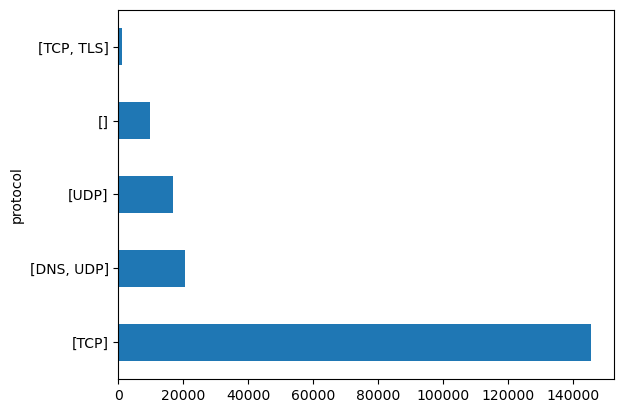

In [17]:
df.protocol.value_counts().plot(kind='barh')

**** DEVICE:  ('Aria',)
PROTOCOLS COUNT


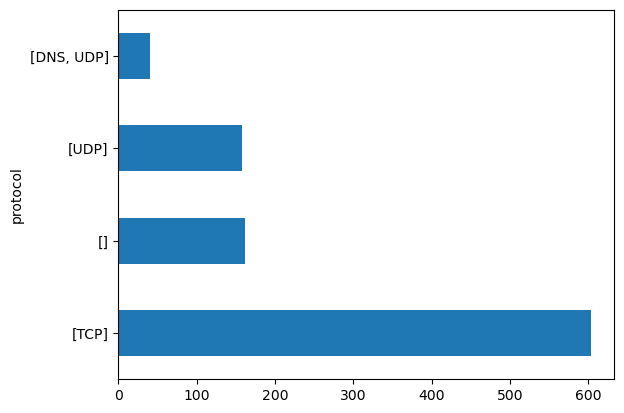

PACKET SIZE HIST


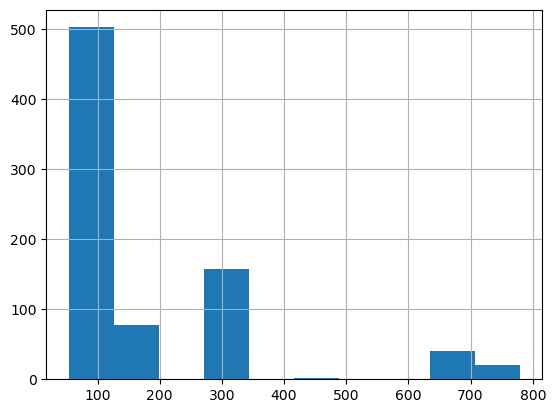

DNS ANSWERS
answers
[]                                                                                                                  20
[b'www.fitbit.com.', b'www.fitbit.com.cdn.cloudflare.net.', b'www.fitbit.com.cdn.cloudflare.net.', 104.16.66.50]    13
[b'www.fitbit.com.', b'www.fitbit.com.cdn.cloudflare.net.', b'www.fitbit.com.cdn.cloudflare.net.', 104.16.65.50]     7
Name: count, dtype: int64
DISTINCT TSVAL VALUES
[nan 0 10]
DISTINCT SRC IPS
[nan '10.10.10.123' '104.16.65.50' '104.16.66.50']
DISTINCT DST IPS
[nan '104.16.65.50' '10.10.10.123' '104.16.66.50']
**** DEVICE:  ('D-LinkCam',)
PROTOCOLS COUNT


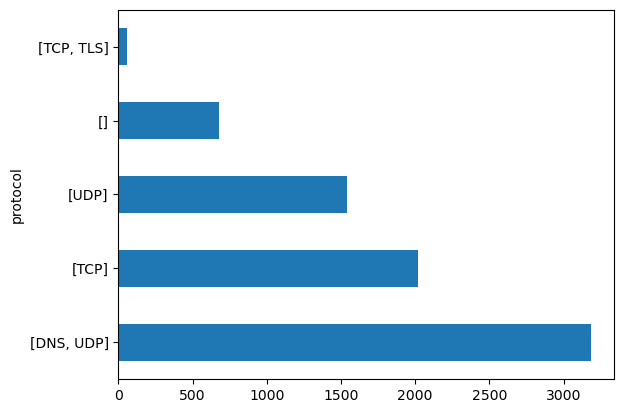

PACKET SIZE HIST


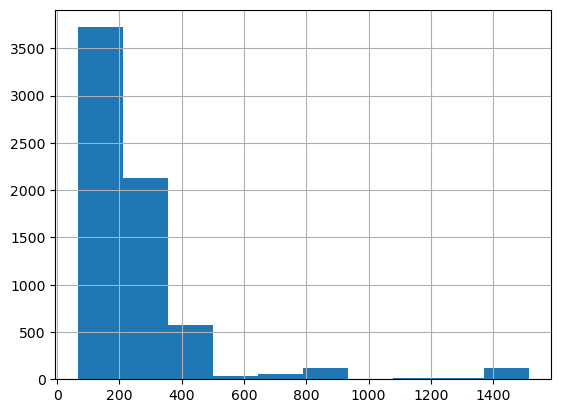

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     1797
[b'dcs-935l.local.', 10.10.10.37, b'D-Link DCS-935L Configuration Utility (2)._http._tcp.local.', [b''], b'D-Link DCS-935L Configuration Utility (2)._http._tcp.local.', [b''], b'_servi

DISTINCT TSVAL VALUES
[nan (2025, 0) (10735248, 2025) ... (4294961516, 13382088)
 (13382090, 4294961516) (4294961519, 13382090)]
DISTINCT SRC IPS
[nan '10.10.10.37' '52.8.86.161' '52.17.177.126' '54.229.64.81'
 '52.8.178.58' '10.10.10.28' '54.194.162.25' '54.193.108.172'
 '54.238.198.198' '52.17.248.50' '54.238.186.67' '54.194.162.61'
 '54.193.41.31' '52.18.83.30' '52.9.16.35' '54.193.40.248' '54.193.40.55'
 '52.8.79.180']
DISTINCT DST IPS
[nan '52.8.86.161' '10.10.10.37' '52.17.177.126' '54.229.64.81'
 '52.8.178.58' '10.10.10.28' '54.194.162.25' '54.193.108.172'
 '54.238.198.198' '52.17.248.50' '54.238.186.67' '54.194.162.61'
 '54.193.41.31' '52.18.83.30' '52.9.16.35' '54.193.40.248' '54.193.40.55'
 '52.8.79.180']
**** DEVICE:  ('D-LinkDayCam',)
PROTOCOLS COUNT


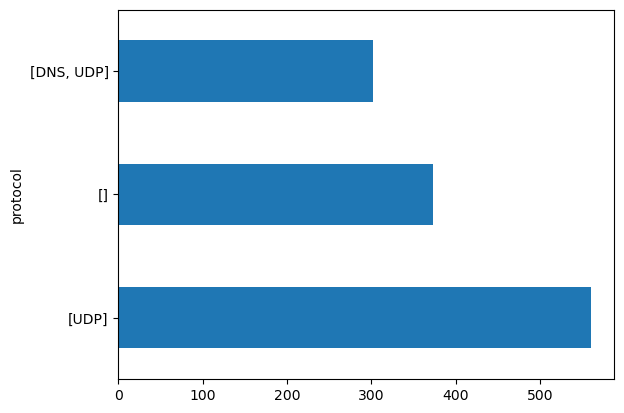

PACKET SIZE HIST


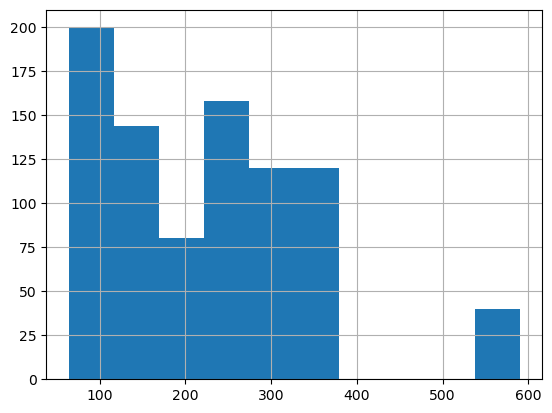

DNS ANSWERS
answers
[b'DCS-930LB1_1C7185.local.', 10.10.10.58, b'58.10.10.10.in-addr.arpa.', b'DCS-930LB1_1C7185.local.', b'DCS-930LB_1C7185._http._tcp.local.', [b''], b'DCS-930LB_1C7185._http._tcp.local.', [b''], b'_services._dns-sd._udp.local.', b'_http._tcp.local.']    158
[]                                                                                                                                                                                                                                                           135
[b'58.10.10.10.in-addr.arpa.', b'DCS-930LB1_1C7185.local.']                                                                                                                                                                                                    8
[b'DCS-930LB1_1C7185.local.', 10.10.10.58, b'DCS-930LB_1C7185._http._tcp.local.', [b''], b'DCS-930LB_1C7185._http._tcp.local.', [b'']]                                                                           

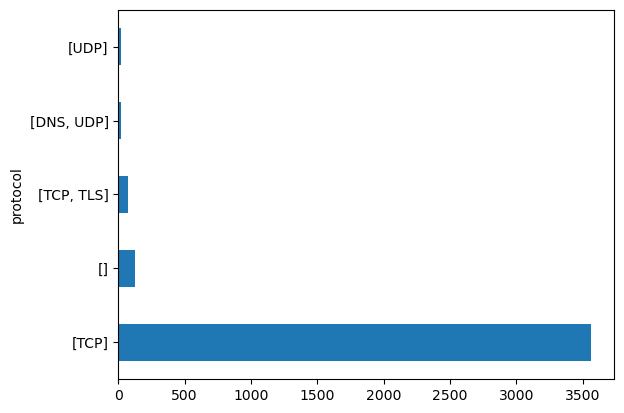

PACKET SIZE HIST


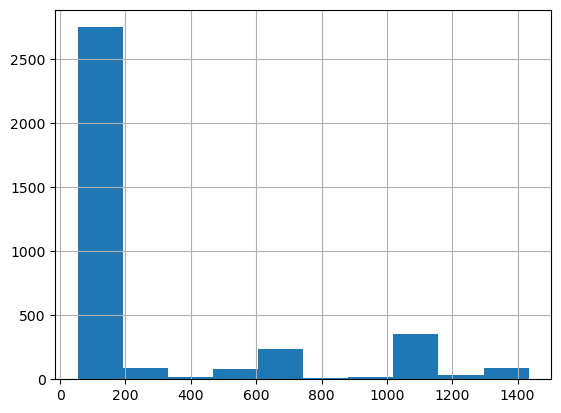

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                               11
[b'api.dch.dlink.com.', b'eu-api-elb-1068129369.eu-central-1.elb.amazonaws.com.', b'eu-api-elb-1068129369.eu-central-1.elb.amazonaws.com.', 52.28.38.154]                                                                                                                                                                                                                                                                                         5
[b'api.dch.dlink.com.', b'eu-api-elb-1068129369.eu-central-1.elb.amazonaws.com.', b'eu-api-elb-1068129369.eu

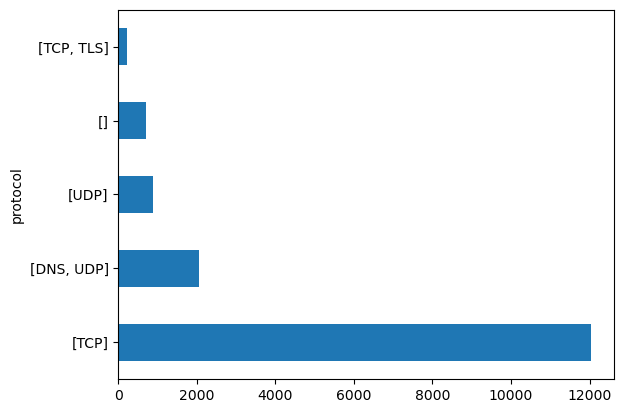

PACKET SIZE HIST


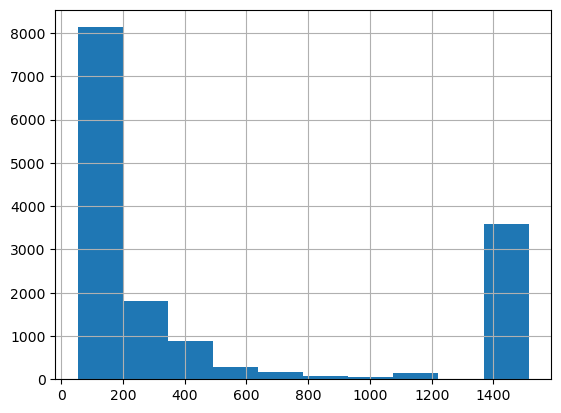

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                            1205
[b'api.dch.dlink.com.', b'eu-api-elb-1068129369.eu-central-1.elb.amazonaws.com.', b'eu-api-elb-1068129369.eu-central-1.elb.amazonaws.com.', 52.28.38.154]                                                                                                                                                                                                                                                       29
[b'api.dch.dlink.com.', b'eu-api-elb-1068129369.eu-central-1.elb.amazonaws.com.', b'eu-api-elb-1068129369.eu-central-1.elb.amazonaws.com.', 52.58.68.165]                     

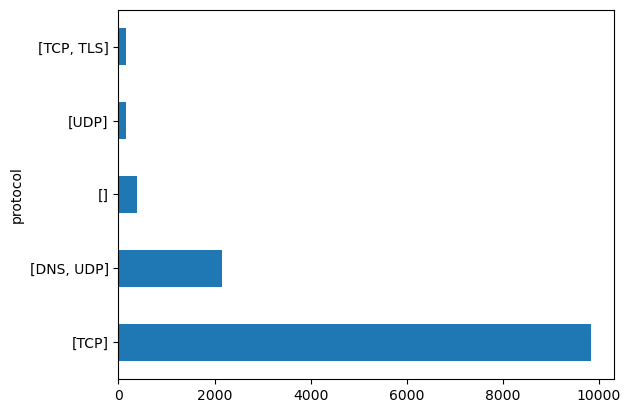

PACKET SIZE HIST


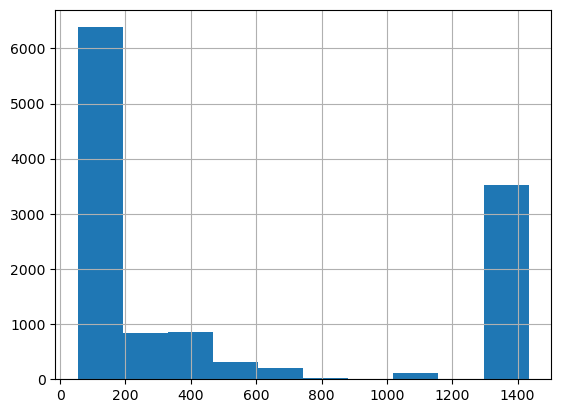

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

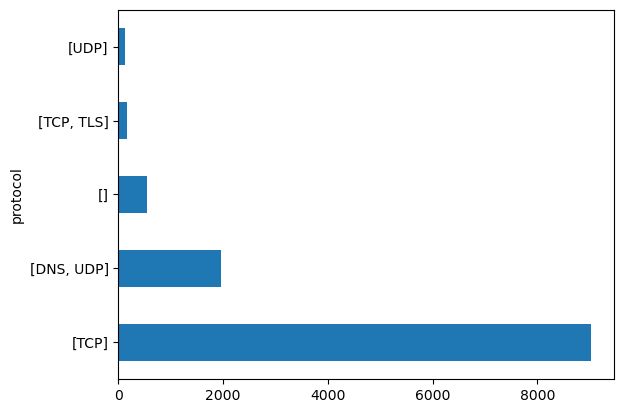

PACKET SIZE HIST


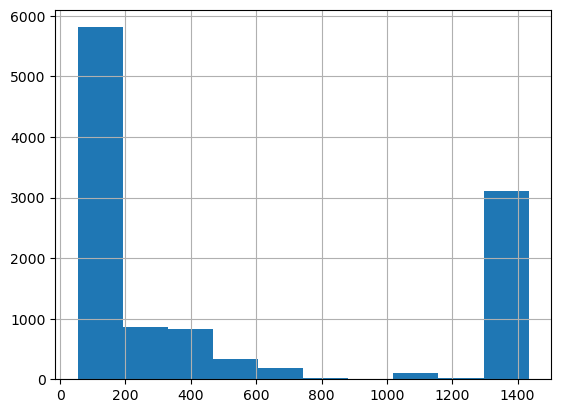

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

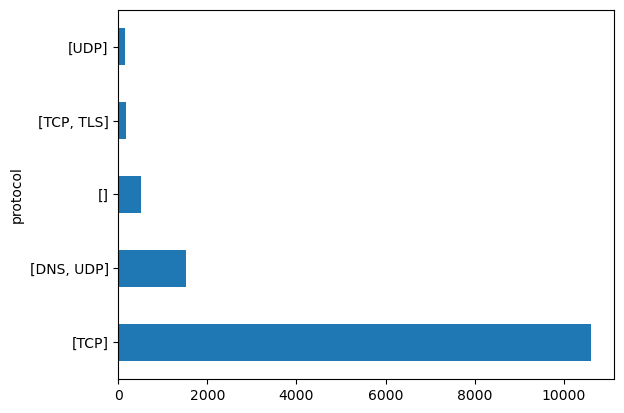

PACKET SIZE HIST


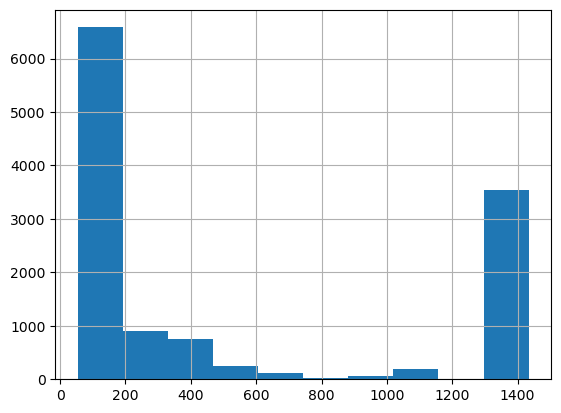

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             775
[b'D-Link HNAP Service._dhnap._tcp.local.', [b'mac=90:8D:78:A9:3D:6F', b'wlan0_ssid=DSP-3D6F', b'model_number=DSP-W215', b'hardware_ver=B2', b'dcs=Sinker', b'ver

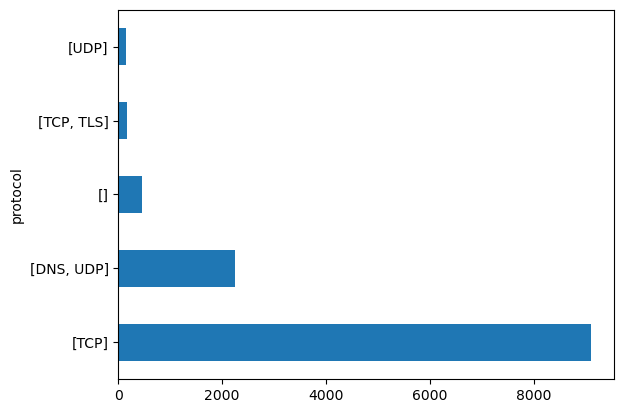

PACKET SIZE HIST


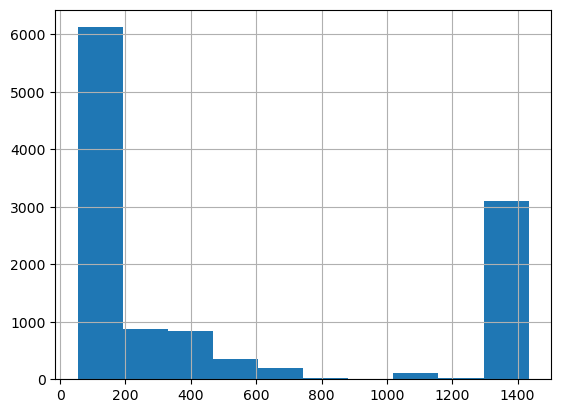

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

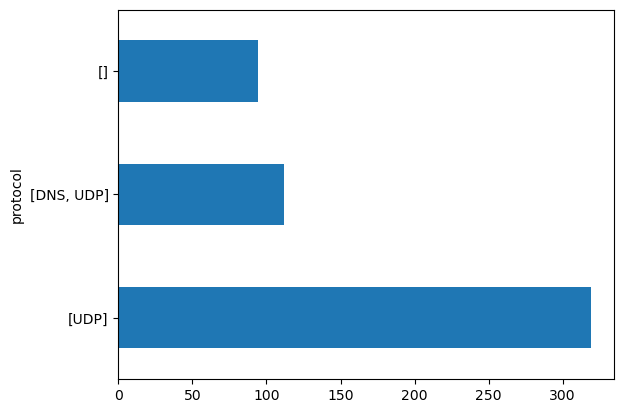

PACKET SIZE HIST


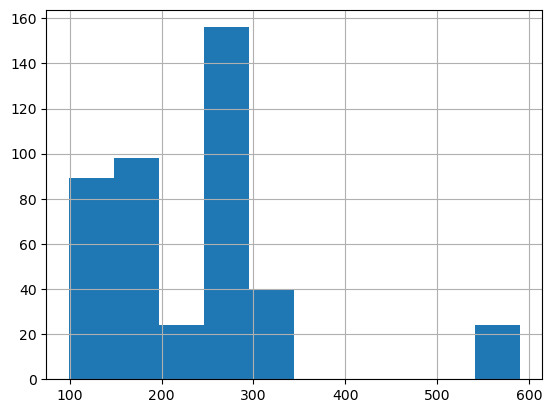

DNS ANSWERS
answers
[b'localcam.local.', 10.10.10.51, b'51.10.10.10.in-addr.arpa.', b'localcam.local.', b' [74:da:38:80:7a:08]._http._tcp.local.', [b'IC-3115W Network Camera'], b' [74:da:38:80:7a:08]._http._tcp.local.', [b'IC-3115W Network Camera'], b'_services._dns-sd._udp.local.', b'_http._tcp.local.']    74
[]                                                                                                                                                                                                                                                                                               36
[b'localcam.local.', 192.168.4.3, b'3.4.168.192.in-addr.arpa.', b'localcam.local.', b' [74:da:38:80:7a:08]._http._tcp.local.', [b'IC-3115W Network Camera'], b' [74:da:38:80:7a:08]._http._tcp.local.', [b'IC-3115W Network Camera'], b'_services._dns-sd._udp.local.', b'_http._tcp.local.']     2
Name: count, dtype: int64
**** DEVICE:  ('EdimaxCam2',)
PROTOCOLS COUNT


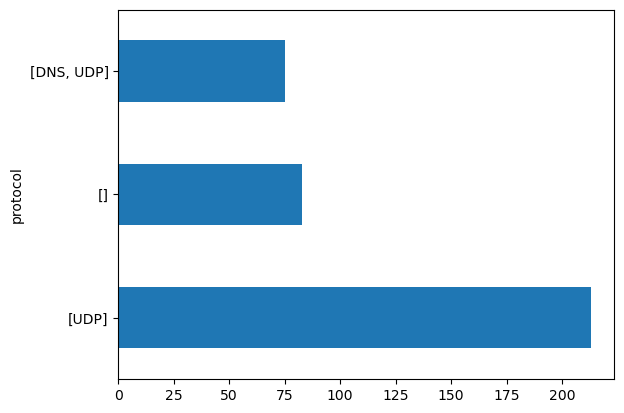

PACKET SIZE HIST


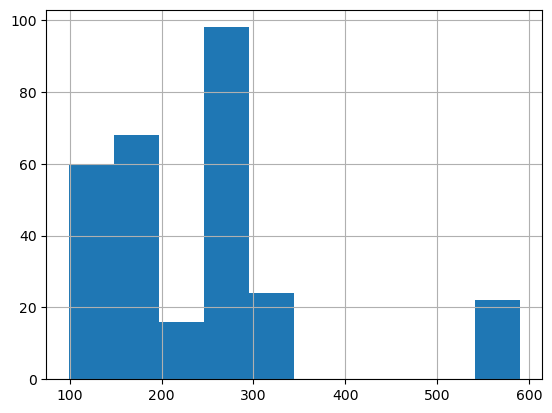

DNS ANSWERS
answers
[b'localcam.local.', 10.10.10.227, b'227.10.10.10.in-addr.arpa.', b'localcam.local.', b' [74:da:38:80:79:fc]._http._tcp.local.', [b'IC-3115W Network Camera'], b' [74:da:38:80:79:fc]._http._tcp.local.', [b'IC-3115W Network Camera'], b'_services._dns-sd._udp.local.', b'_http._tcp.local.']    50
[]                                                                                                                                                                                                                                                                                                 24
[b' [74:da:38:80:79:fc]._http._tcp.local.', [b'IC-3115W Network Camera'], b'_services._dns-sd._udp.local.', b'_http._tcp.local.']                                                                                                                                                                   1
Name: count, dtype: int64
**** DEVICE:  ('EdimaxPlug1101W',)
PROTOCOLS COUNT


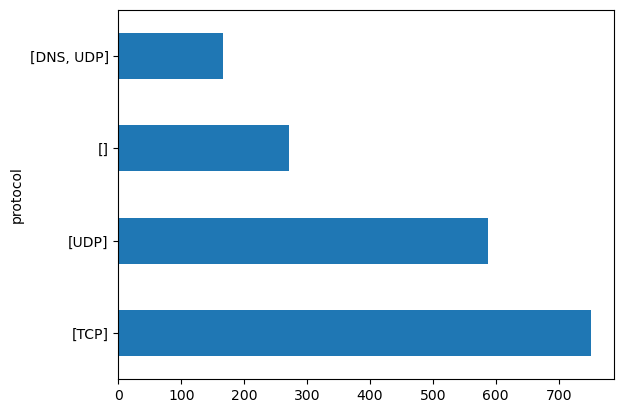

PACKET SIZE HIST


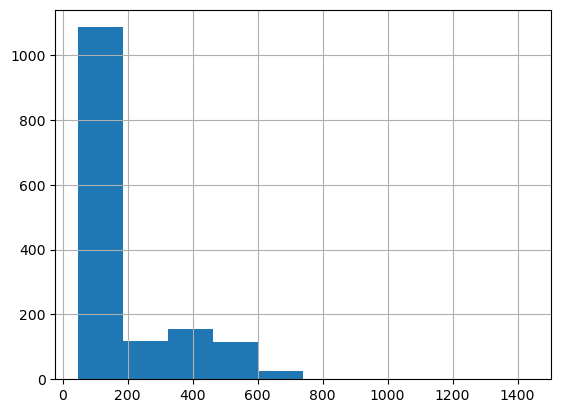

DNS ANSWERS
answers
[]                                                                                                                                                                                     116
[b'www.myedimax.com.', b'ns.myedimax.com.']                                                                                                                                             20
[b'www.google.com.', 74.125.136.104, b'www.google.com.', 74.125.136.103, b'www.google.com.', 74.125.136.99, b'www.google.com.', 74.125.136.147, b'www.google.com.', 74.125.136.106]      4
[b'www.google.com.', 74.125.136.103, b'www.google.com.', 74.125.136.99, b'www.google.com.', 74.125.136.147, b'www.google.com.', 74.125.136.106, b'www.google.com.', 74.125.136.105]      2
[b'www.google.com.', 74.125.136.105, b'www.google.com.', 74.125.136.104, b'www.google.com.', 74.125.136.103, b'www.google.com.', 74.125.136.99, b'www.google.com.', 74.125.136.147]      2
[b'pool.ntp.org.', 178.63.135.195, b'pool.ntp

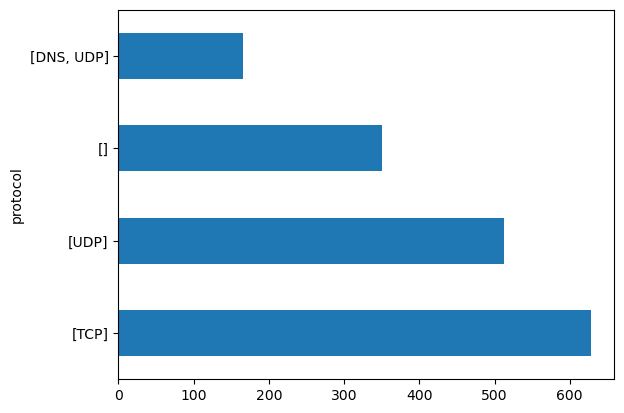

PACKET SIZE HIST


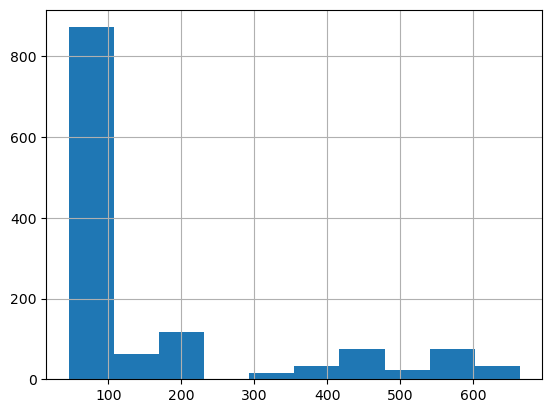

DNS ANSWERS
answers
[]                                                                                                                                                                                      115
[b'www.myedimax.com.', b'ns.myedimax.com.']                                                                                                                                              20
[b'www.google.com.', 74.125.136.106, b'www.google.com.', 74.125.136.105, b'www.google.com.', 74.125.136.104, b'www.google.com.', 74.125.136.103, b'www.google.com.', 74.125.136.99]       3
[b'www.google.com.', 74.125.136.147, b'www.google.com.', 74.125.136.106, b'www.google.com.', 74.125.136.105, b'www.google.com.', 74.125.136.104, b'www.google.com.', 74.125.136.103]      2
[b'pool.ntp.org.', 121.0.0.42, b'pool.ntp.org.', 199.233.236.226, b'pool.ntp.org.', 218.186.3.36]                                                                                         1
[b'www.google.com.', 74.125.136.104, b'w

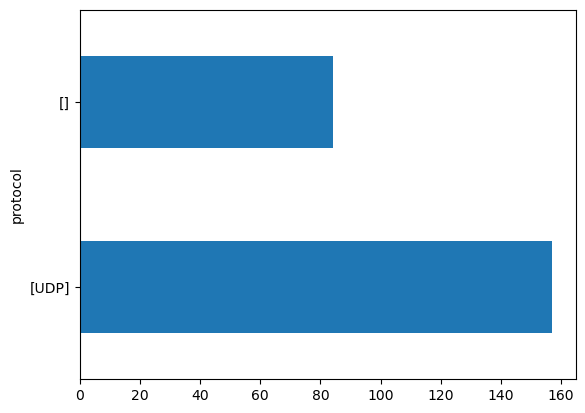

PACKET SIZE HIST


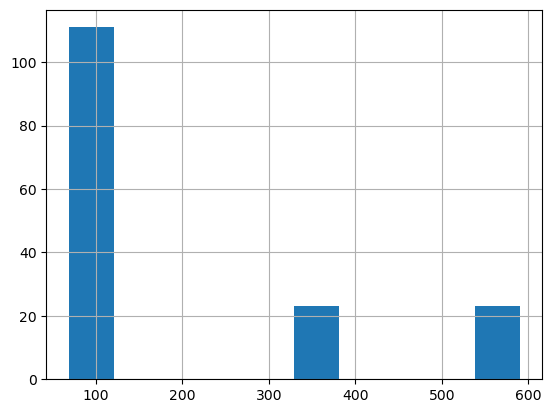

**** DEVICE:  ('EdnetCam2',)
PROTOCOLS COUNT


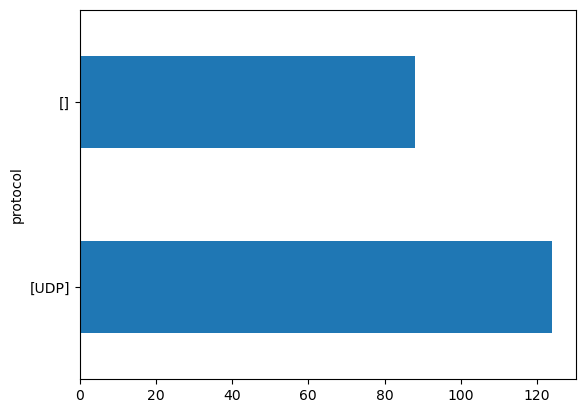

PACKET SIZE HIST


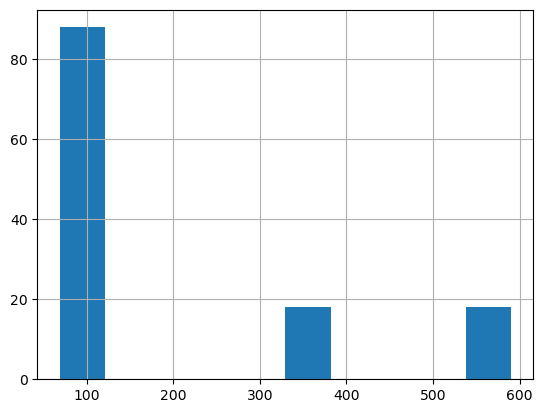

**** DEVICE:  ('EdnetGateway',)
PROTOCOLS COUNT


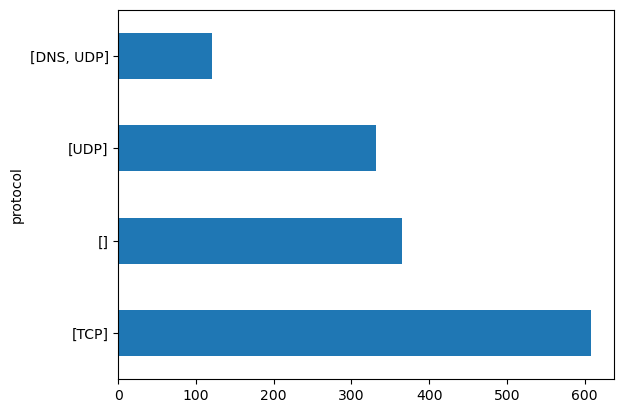

PACKET SIZE HIST


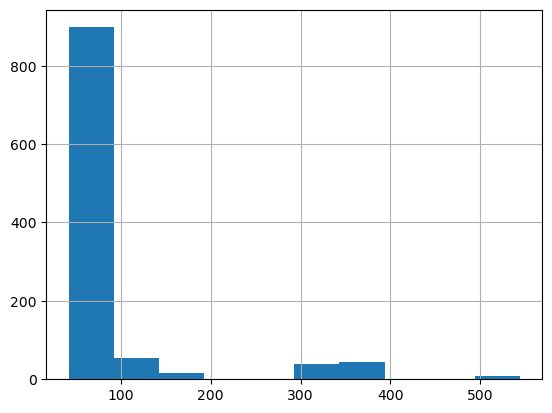

DNS ANSWERS
answers
[]                                                                                                             100
[b'0.pool.ntp.org.', 185.28.157.12, b'0.pool.ntp.org.', 129.250.35.250, b'0.pool.ntp.org.', 144.76.115.197]      1
[b'0.pool.ntp.org.', 185.19.196.101, b'0.pool.ntp.org.', 87.106.126.46, b'0.pool.ntp.org.', 78.46.53.8]          1
[b'0.pool.ntp.org.', 144.76.14.132, b'0.pool.ntp.org.', 46.165.212.205, b'0.pool.ntp.org.', 46.165.212.204]      1
[b'0.pool.ntp.org.', 91.207.136.50, b'0.pool.ntp.org.', 86.59.13.46, b'0.pool.ntp.org.', 201.49.148.135]         1
[b'0.pool.ntp.org.', 129.70.132.33, b'0.pool.ntp.org.', 62.116.162.126, b'0.pool.ntp.org.', 213.206.164.3]       1
[b'0.pool.ntp.org.', 211.233.84.186, b'0.pool.ntp.org.', 200.192.232.8, b'0.pool.ntp.org.', 178.17.160.12]       1
[b'0.pool.ntp.org.', 146.0.32.144, b'0.pool.ntp.org.', 178.63.9.110, b'0.pool.ntp.org.', 37.120.183.57]          1
[b'0.pool.ntp.org.', 213.136.0.252, b'0.pool.ntp.org.', 87.2

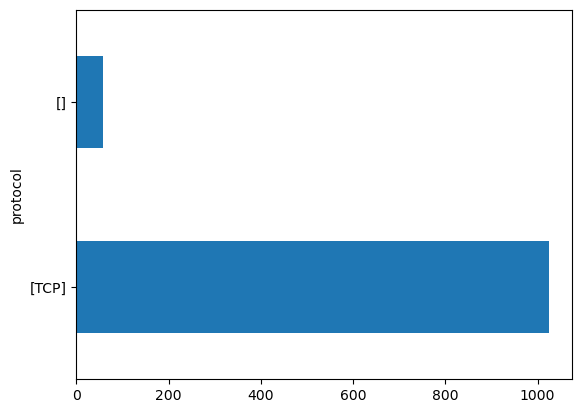

PACKET SIZE HIST


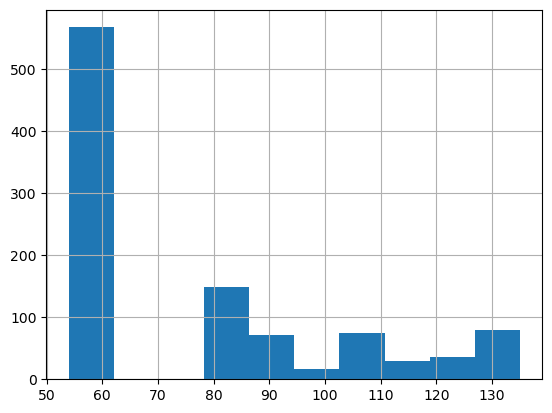

**** DEVICE:  ('HueBridge',)
PROTOCOLS COUNT


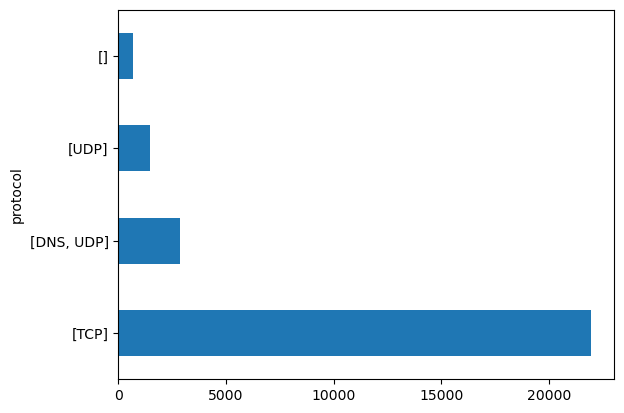

PACKET SIZE HIST


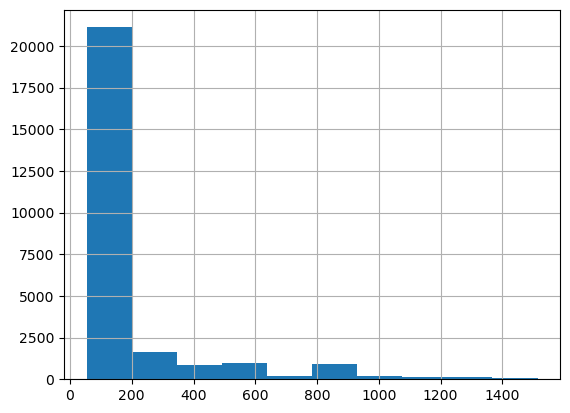

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                 2316
[b'bridge.meethue.com.', b'ghs-svc-https-c157.ghs-ssl.googlehosted.com.']                                                                                                                                                                                                                                           174
[b'Philips hue - 2476FF._hap._tcp.local.', [b'c#=2', b'ff=1', b'id=00:17:88:24:76:FF', b'md=BSB002', b'pv=1.0', b'sf=1', b's#=4', b'ci=2'], b'Philips hue - 2476FF._hap._tcp.local.', [b'c#=2', b'ff=1', b'id=00:17:88:24:76:FF', b'md=BSB002', b'pv=1.0', b'sf=1', b's#=4', b'ci=2']]                               90
[b'Philips-hue.local.', 10.10.10.6, b'_hap._

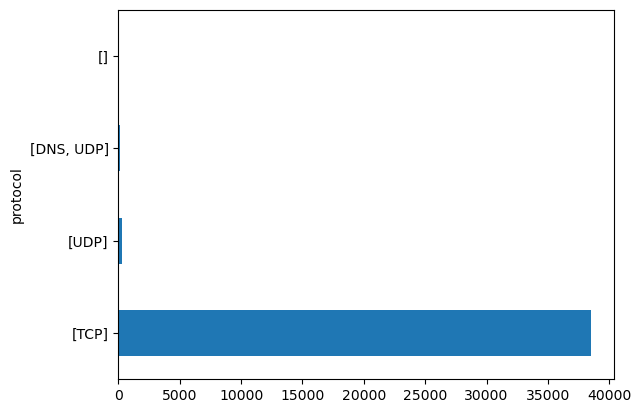

PACKET SIZE HIST


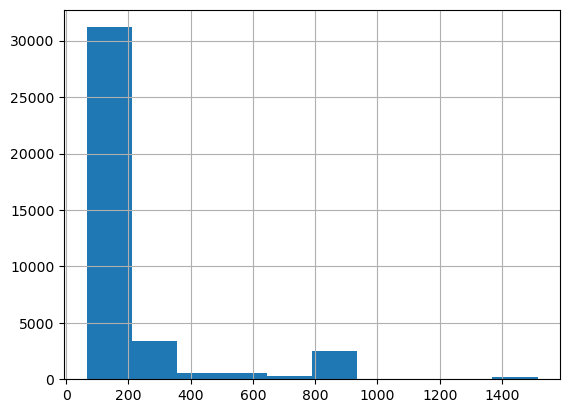

DNS ANSWERS
answers
[]                                                                                                                                              108
[b'Philips hue - 2476FF._hap._tcp.local.', [b'c#=2', b'ff=1', b'id=00:17:88:24:76:FF', b'md=BSB002', b'pv=1.0', b'sf=1', b's#=85', b'ci=2']]      6
[b'Philips hue - 2476FF._hap._tcp.local.', [b'c#=2', b'ff=1', b'id=00:17:88:24:76:FF', b'md=BSB002', b'pv=1.0', b'sf=1', b's#=20', b'ci=2']]      6
[b'Philips hue - 2476FF._hap._tcp.local.', [b'c#=2', b'ff=1', b'id=00:17:88:24:76:FF', b'md=BSB002', b'pv=1.0', b'sf=1', b's#=33', b'ci=2']]      6
Name: count, dtype: int64
DISTINCT TSVAL VALUES
[(1608552, 0) (1608555, 660045) (1608556, 660045) ... (14496545, 175177)
 (14496546, 175177) (175178, 14496546)]
DISTINCT SRC IPS
['10.10.10.30' '10.10.10.6' nan]
DISTINCT DST IPS
['10.10.10.6' '10.10.10.30' nan]
**** DEVICE:  ('Lightify',)
PROTOCOLS COUNT


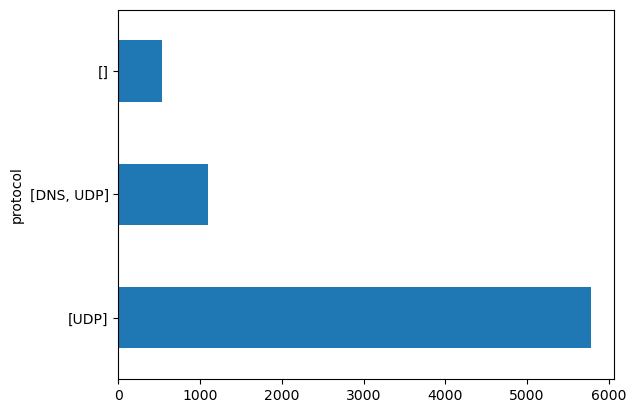

PACKET SIZE HIST


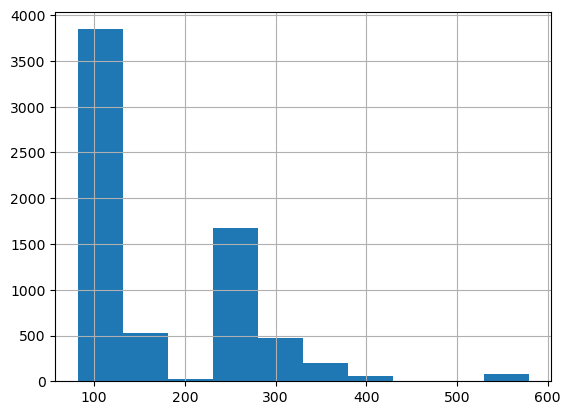

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                          137
[b'Lightify-017b5f6b._http._tcp.local.', b'Lightify-017b5f6b._http._tcp.local.', b'_http._tcp.local.', b'Lightify-017b5f6b._http._tcp.local.']                                                                                                                                                                                                                                                                                                                               90
[b'Lightify-017b5f6b._http._tcp.local.', [b'txtvers=

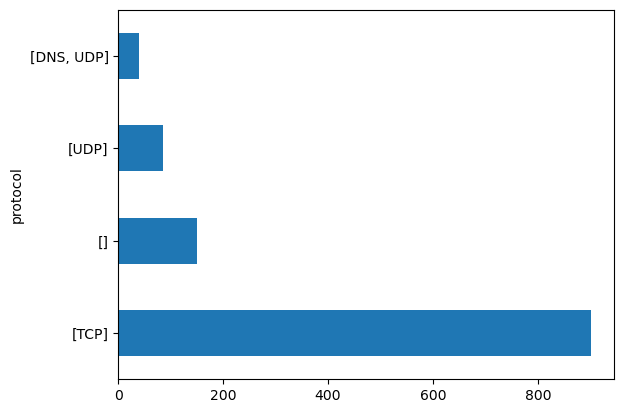

PACKET SIZE HIST


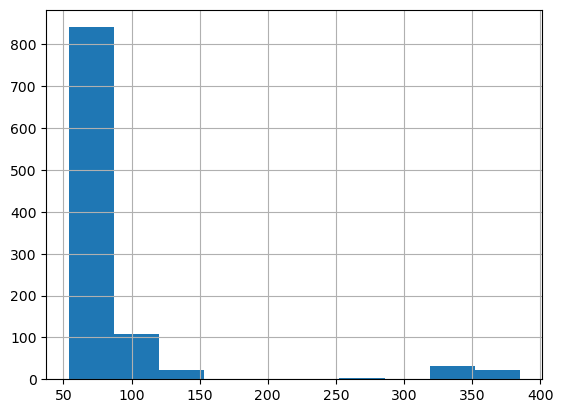

DNS ANSWERS
answers
[]                                            20
[b'ntp.homematic.com.', b'homematic.com.']    19
Name: count, dtype: int64
DISTINCT TSVAL VALUES
[nan 8 (30615869, 0) (30616069, 0) (30619306, 0) (30619506, 0)
 (30622745, 0) (30622945, 0) (30643298, 0) (30643498, 0) (30646741, 0)
 (30646942, 0) (30588421, 0) (30588621, 0) (30591862, 0) (30592062, 0)
 (30595308, 0) (30595508, 0) (30554043, 0) (30554243, 0) (30557486, 0)
 (30557686, 0) (30560926, 0) (30561126, 0) (30564368, 0) (30564568, 0)
 (30567808, 0) (30568008, 0)]
DISTINCT SRC IPS
[nan '10.10.10.127' '10.10.10.30']
DISTINCT DST IPS
[nan '10.10.10.129']
**** DEVICE:  ('SmarterCoffee',)
PROTOCOLS COUNT


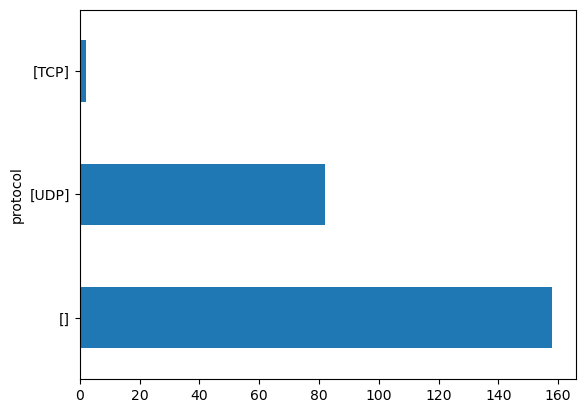

PACKET SIZE HIST


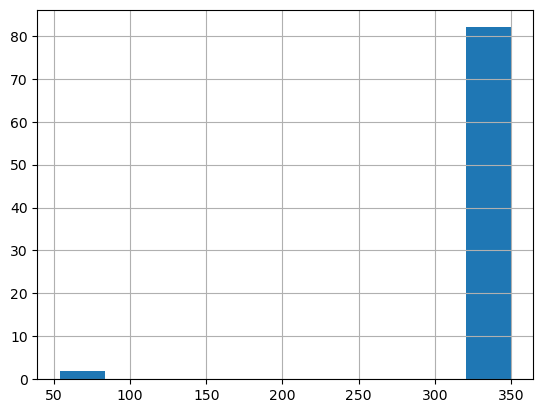

**** DEVICE:  ('TP-LinkPlugHS100',)
PROTOCOLS COUNT


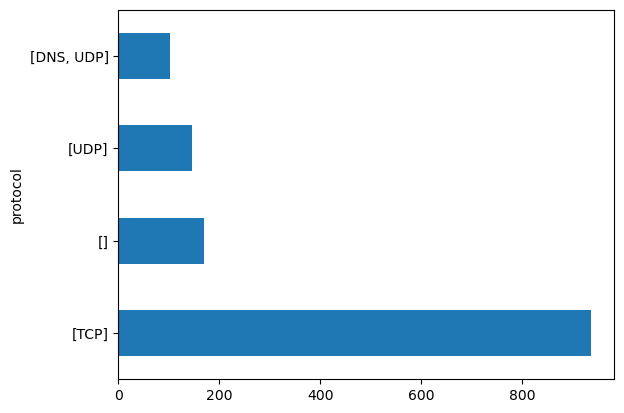

PACKET SIZE HIST


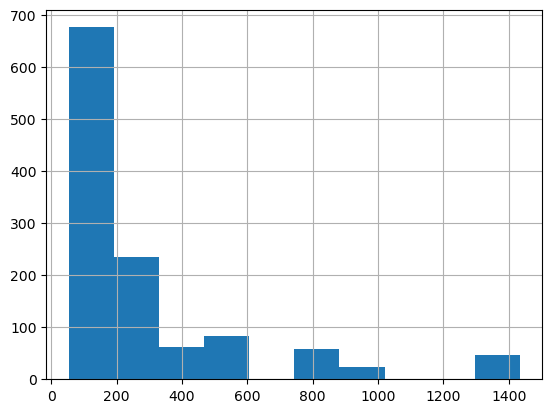

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                         61
[b'devs.tplinkcloud.com.', b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 52.18.200.165, b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 52.49.65.150, b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 52.49.107.41]      10
[b'devs.tplinkcloud.com.', b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 52.49.65.150, b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 52.49.107.41, b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 5

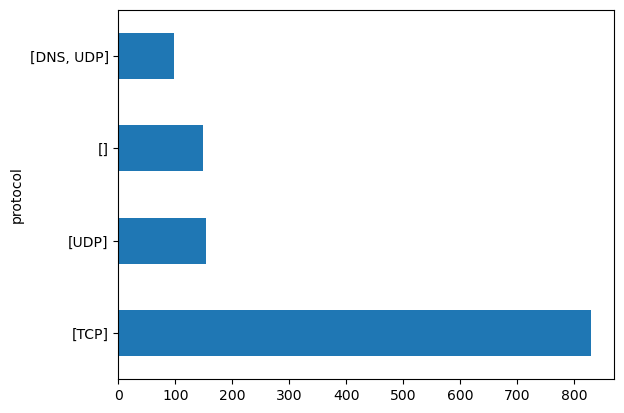

PACKET SIZE HIST


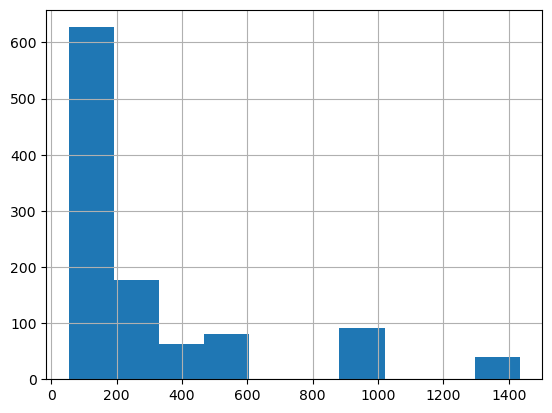

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                         60
[b'devs.tplinkcloud.com.', b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 52.209.224.132, b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 52.18.200.165, b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 52.49.65.150]     7
[b'devs.tplinkcloud.com.', b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 52.49.65.150, b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 52.49.107.41, b'prd-elb-connector-0-1621750456.eu-west-1.elb.amazonaws.com.', 5

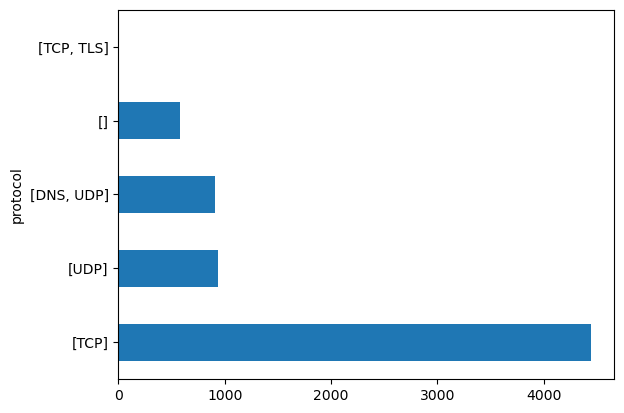

PACKET SIZE HIST


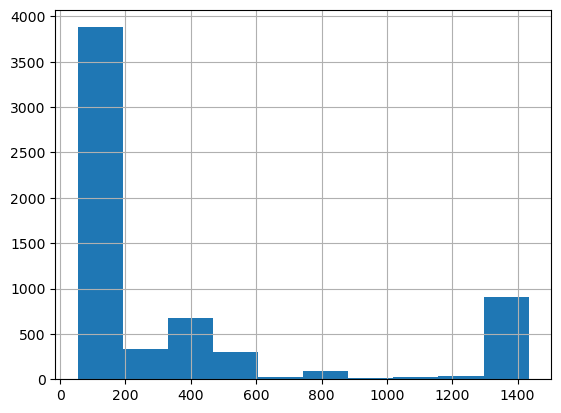

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              615
[b'android.clients.google.com.', b'android.l.google.com.']                                                                                                                                                                                                                                                                                                      

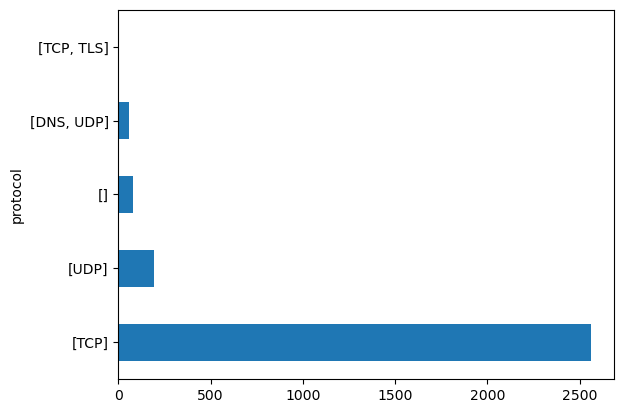

PACKET SIZE HIST


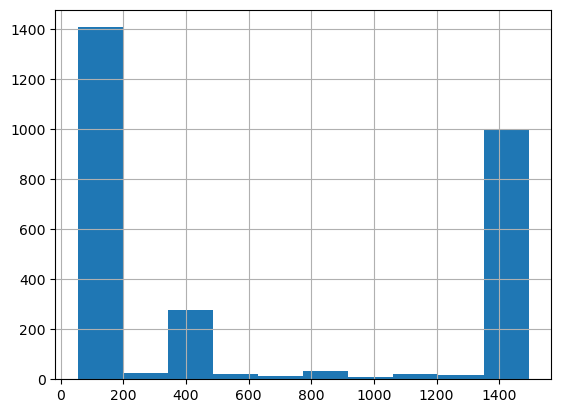

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               30
[b'nat.xbcs.net.', b'prod1-nat-xbcs-net-1543133972.us-east-1.elb.amazonaws.com.', b'prod1-nat-xbcs-net-1543133972.us-east-1.elb.amazonaws.com.', 50.19.247.85]                                                                                                                                                                                                  

DISTINCT TSVAL VALUES
[nan (58304466, 0) None (58347248, 0) (58257611, 0) (58212906, 0)
 (58213106, 0)]
DISTINCT SRC IPS
[nan '10.22.22.138' '10.10.10.124' '107.22.199.21' '50.19.247.85'
 '54.80.113.88' '23.21.60.181' '23.23.97.224' '23.21.145.73'
 '23.23.236.208' '50.16.203.253' '54.166.254.31' '54.225.150.170'
 '54.235.111.253' '50.19.90.237' '54.198.137.31' '107.21.214.151'
 '54.159.82.228' '23.23.244.247' '54.163.33.123']
DISTINCT DST IPS
[nan '216.34.140.195' '107.22.199.21' '10.10.10.124' '50.19.247.85'
 '54.80.113.88' '23.21.60.181' '23.23.97.224' '23.21.145.73'
 '23.23.236.208' '50.16.203.253' '54.166.254.31' '54.225.150.170'
 '54.235.111.253' '50.19.90.237' '54.198.137.31' '107.21.214.151'
 '54.159.82.228' '23.23.244.247' '54.163.33.123']
**** DEVICE:  ('WeMoLink',)
PROTOCOLS COUNT


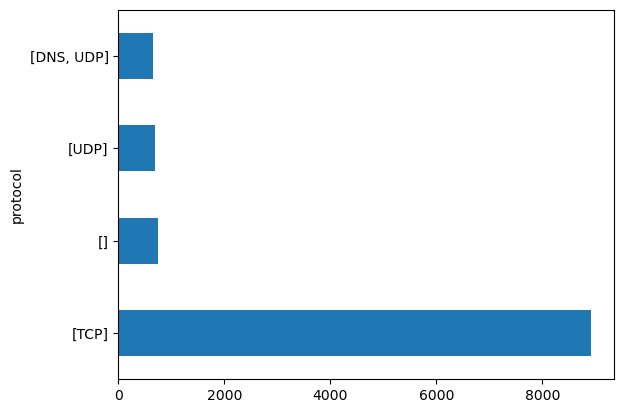

PACKET SIZE HIST


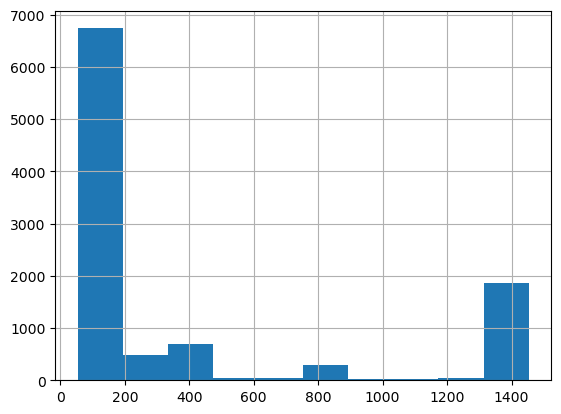

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            338
[b'mtalk4.google.com.', b'mobile-gtalk4.l.google.com.']                                                                                                                                                                                                                                           

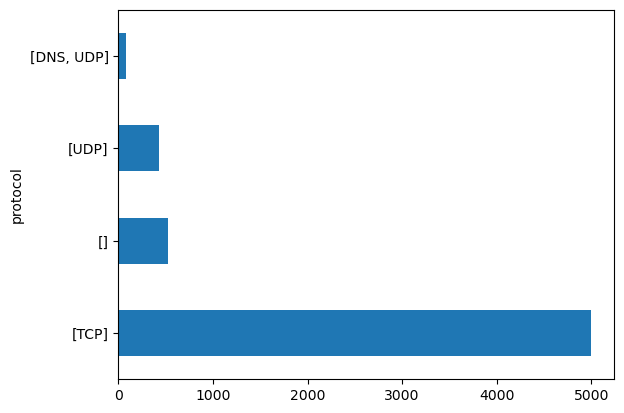

PACKET SIZE HIST


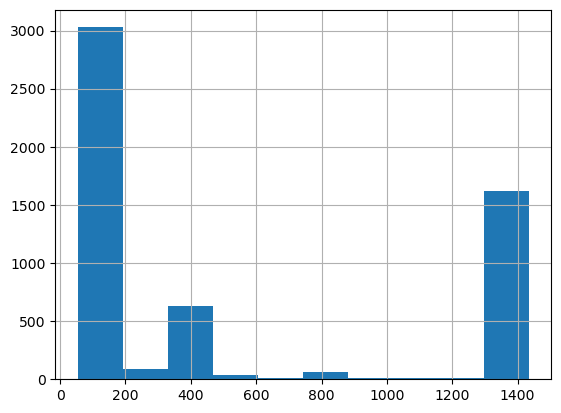

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                42
[b'nat.xbcs.net.', b'prod1-nat-xbcs-net-1543133972.us-east-1.elb.amazonaws.com.', b'prod1-nat-xbcs-net-1543133972.us-east-1.elb.amazonaws.com.', 23.23.244.247]                                                                                                                                                                                                

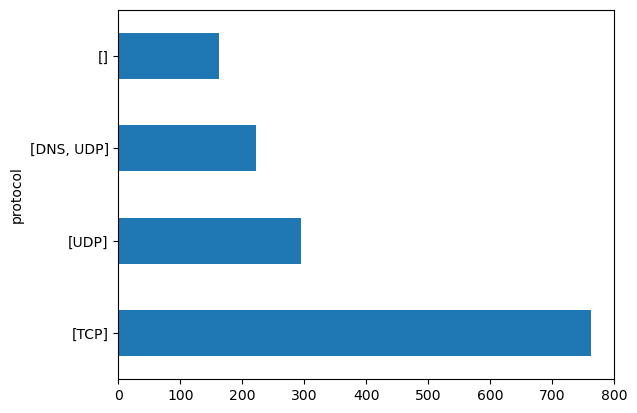

PACKET SIZE HIST


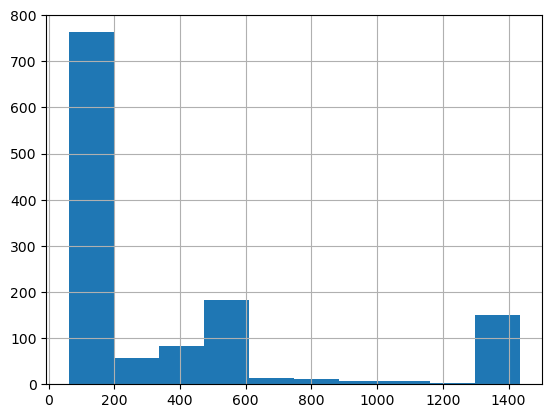

DNS ANSWERS
answers
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          183
[b'mtalk4.google.com.', b'mobile-gtalk4.l.google.com.']                                                                                                                                                                                                                                             

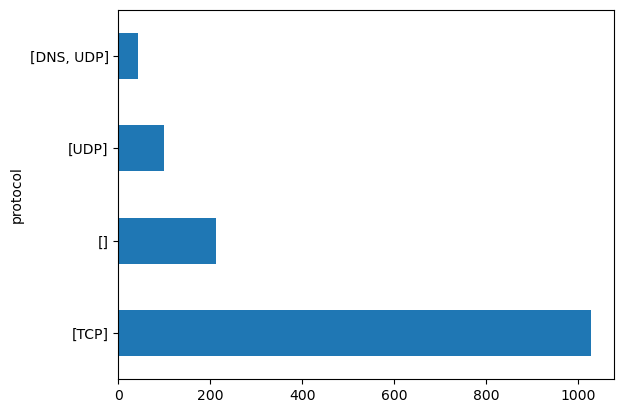

PACKET SIZE HIST


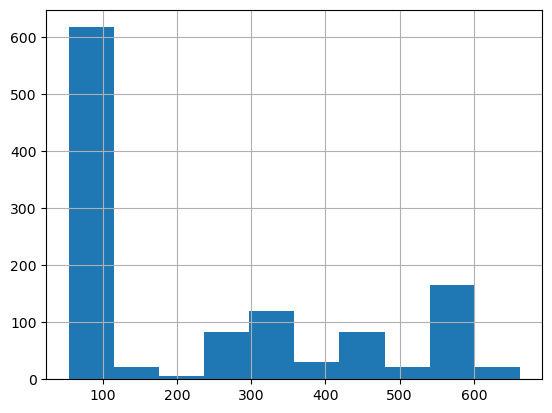

DNS ANSWERS
answers
[]    42
Name: count, dtype: int64
**** DEVICE:  ('iKettle2',)
PROTOCOLS COUNT


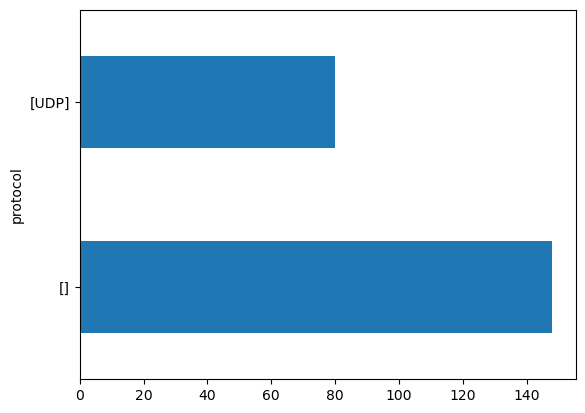

PACKET SIZE HIST


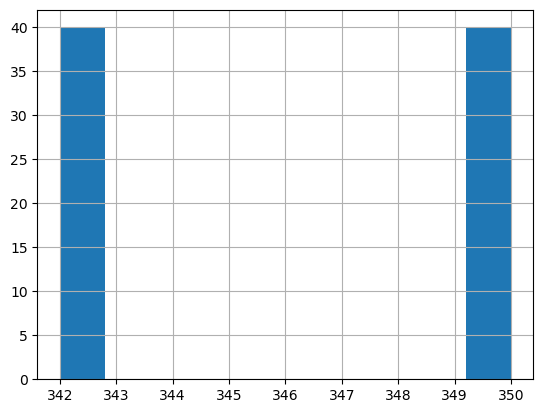

In [88]:
for i, g in df.groupby(['pcap_folder']):
    print('**** DEVICE: ', i)
    print('PROTOCOLS COUNT')
    g.protocol.value_counts().plot(kind='barh')
    plt.show()
    print('PACKET SIZE HIST')
    g.packet_size.hist()
    plt.show()
    if len(g.answers.value_counts()) > 0:
        print('DNS ANSWERS')
        print(g.answers.value_counts())
    if len(g.sni.value_counts()) > 0:
        print('SNI')
        print(g.answers.value_counts())
    if g.tsval.nunique() > 0:
        print('DISTINCT TSVAL VALUES')
        print(g.tsval.unique())
    if g.src_ip.nunique() > 0:
        print('DISTINCT SRC IPS')
        print(g.src_ip.unique())
    if g.dst_ip.nunique() > 0:
        print('DISTINCT DST IPS')
        print(g.dst_ip.unique())
    

##### Relevant features per column
- protocol
    1. protocol name (categorical)
    2. protocol num. of appearances (numerical)
- packet_size
    1. mean packet size (numerical)
    2. mean time-diff between packets (numerical)
- tsval
    1. mean tsval (numerical)
- answers (categorical)
- sni (categorical)

- LABEL - pcap_folder